<a href="https://colab.research.google.com/github/Tomortec/Tomortec/blob/main/nbs/docs/use-cases/2_bitcoin_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#| hide
!pip install -Uqq nixtla cryptocmd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.8 MB/s eta 0:00:00


In [2]:
#| hide
from nixtla.utils import in_colab

In [3]:
#| hide
IN_COLAB = in_colab()

In [4]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

In [27]:
# !pwd
# !mkdir ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download mczielinski/bitcoin-historical-data

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
 81% 78.0M/95.7M [00:00<00:00, 809MB/s]
100% 95.7M/95.7M [00:00<00:00, 799MB/s]


In [28]:
!unzip bitcoin-historical-data.zip

Archive:  bitcoin-historical-data.zip
  inflating: btcusd_1-min_data.csv   


# Bitcoin price prediction

> Learn how to use TimeGPT for financial time series forecasting

## Introduction

Forecasting time series is a ubiquitous task in finance, supporting decisions in trading, risk management, and strategic planning. Despite its prevalence, predicting the future prices of financial assets remains a formidable challenge, mainly due to the inherent volatility of financial markets.

For those who believe in the feasibility of forecasting these assets, or for professionals whose roles require such predictions, TimeGPT is a powerful tool that simplifies the forecasting process.

In this tutorial, we will demonstrate how to use TimeGPT for financial time series forecasting, focusing on Bitcoin price prediction. We will also showcase how to use TimeGPT for uncertainty quantification, which is essential for risk management and decision-making.

**Outline:**

1. [Load Bitcoin Price Data](#load-bitcoin-price-data)

2. [Get Started with TimeGPT](#get-started-with-timegpt)

3. [Visualize the Data](#visualize-the-data)

4. [Forecast with TimeGPT](#forecast-with-timegpt)

5. [Extend Bitcon Price Analysis with TimeGPT](#extend-bitcoin-price-analysis-with-timegpt)

6. [Understand the Model's Limitations](#understand-the-models-limitations)

7. [References and Additional Material](#references-and-additional-material)

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/use-cases/2_bitcoin_price_prediction')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/use-cases/2_bitcoin_price_prediction.ipynb)

In [5]:
!pip install kagglehub[pandas-datasets]

In [7]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [24]:
import kagglehub

# Download latest version
# Data source: BitStamp Spot
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")
print(path)

/kaggle/input/bitcoin-historical-data


## 1. Load Bitcoin Price Data

Bitcoin (₿) is the first decentralized digital currency and is one of the most popular cryptocurrencies. Transactions are managed and recorded on a public ledger known as the blockchain. Bitcoins are created as a reward for mining, a process that involves solving complex cryptographic tasks to verify transactions. This digital currency can be used as payment for goods and services, traded for other currencies, or held as a store of value.

In this tutorial, we will first download the historical Bitcoin price data in USD as a `pandas` DataFrame.

In [58]:
import pandas as pd

# df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/bitcoin_price_usd.csv', sep=',')
df = pd.read_csv("./btcusd_1-min_data.csv")[::-1][0:2000]

df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.floor('T')
df.rename(columns={'Timestamp': 'Date'}, inplace=True)
df = df.sort_values('Date').reset_index(drop=True)
df = df[['Date', 'Close']]

print(df.iloc[-1])

dup_dates = df[df.duplicated(subset='Date', keep=False)]

if not dup_dates.empty:
    print("发现重复的 Date 行：")
    print(dup_dates)
else:
    print("没有发现重复的 Date。")

print(df.head())
print(df.shape[0])

Date     2025-08-08 23:57:00
Close               116678.0
Name: 1999, dtype: object
没有发现重复的 Date。
                 Date     Close
0 2025-08-07 14:38:00  116631.0
1 2025-08-07 14:39:00  116665.0
2 2025-08-07 14:40:00  116571.0
3 2025-08-07 14:41:00  116479.0
4 2025-08-07 14:42:00  116440.0
2000


/tmp/ipython-input-1681291721.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s').dt.floor('T')


This dataset contains the closing price of Bitcoin in USD from 2020-01-01 to 2023-12-31. It's important to note that unlike traditional financial assets, Bitcoin trades 24/7. Therefore, the closing price represents the price of Bitcoin at a specific time each day, rather than at the end of a trading day.

For convenience, we will rename the `Date` and `Close` columns to `ds` and `y`, respectively.

In [59]:
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

## 2. Get Started with TimeGPT

To get started with `TimeGPT`, you need to instantiate the `NixtlaClient` class. For this, you will need a Nixtla API key.

In [41]:
from nixtla import NixtlaClient

In [42]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'nixak-PZnVEExQt2ltWYQzL6nQj0fMVqmuuSbp5mkJufkxtKNBCfHPcgmtxIqUeU8VdsW4d5MhQ3UtUqcYI9RU'
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

To learn more about how to set up your API key, please refer to the [Setting Up Your Authentication API Key](https://docs.nixtla.io/docs/getting-started-setting_up_your_api_key) tutorial.

## 3. Visualize the Data

Before attempting any forecasting, it is good practice to visualize the data we want to predict. The `NixtlaClient` class includes a `plot` method for this purpose.

The `plot` method has an `engine` argument that allows you to choose between different plotting libraries. Default is `matplotlib`, but you can also use `plotly` for interactive plots.

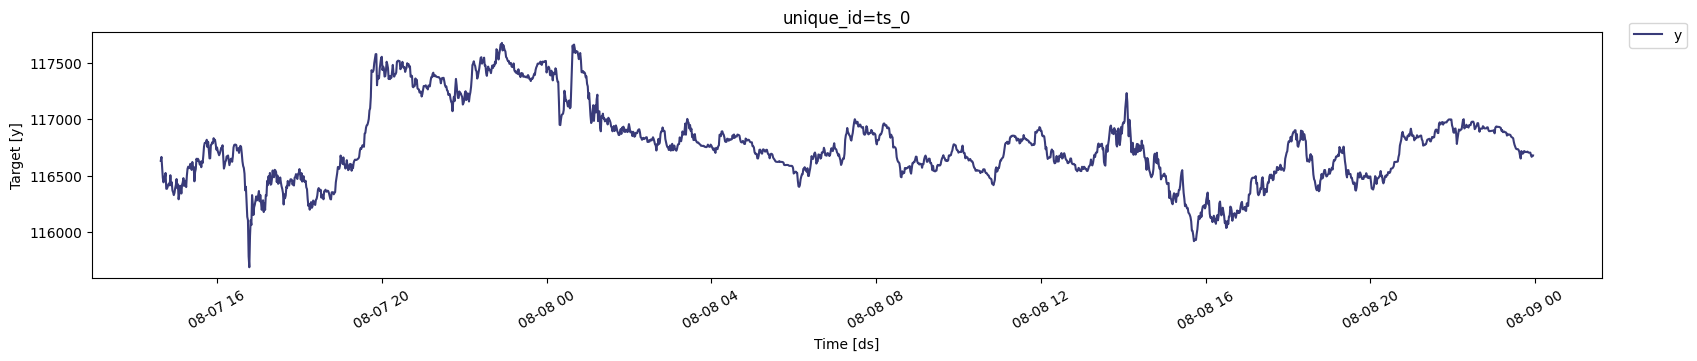

In [53]:
nixtla_client.plot(df)

If you haven't renamed the column names of your DataFrame to `ds` and `y`, you will need to specify the `time_col` and `target_col` arguments of the `plot`method:

``` python
nixtla_client.plot(df, time_col='name of your time column', target_col='name of your target column')
```

This is necessary not only for the `plot` method but for all methods from the `NixtlaClient` class.

## 4. Forecast with TimeGPT

Now we are ready to generate predictions with TimeGPT. To do this, we will use the `forecast` method from the `NixtlaClient` class.

The `forecast` method requires the following arguments:

- `df`: The DataFrame containing the time series data

- `h`: (int) The forecast horizon. In this case, we will forecast the next 7 days.

- `level`: (list) The confidence level for the prediction intervals. Given the inherent volatility of Bitcoin, we will use multiple confidence levels.

In [65]:
level = [50,80,90] # confidence levels

fcst = nixtla_client.forecast(df, h=15, level=level)
fcst

,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2025-08-08 23:58:00,116681.920,116689.410,116708.340,116719.100,116674.440,116655.500,116644.740
1,2025-08-08 23:59:00,116683.300,116708.950,116739.830,116741.220,116657.640,116626.766,116625.375
2,2025-08-09 00:00:00,116683.930,116712.800,116742.330,116748.270,116655.060,116625.530,116619.586
3,2025-08-09 00:01:00,116683.450,116722.660,116741.055,116755.600,116644.250,116625.850,116611.305
4,2025-08-09 00:02:00,116683.900,116727.520,116785.660,116795.110,116640.270,116582.140,116572.690
5,2025-08-09 00:03:00,116686.680,116726.330,116768.310,116798.350,116647.030,116605.050,116575.010
6,2025-08-09 00:04:00,116691.640,116722.960,116777.195,116815.805,116660.320,116606.086,116567.480
7,2025-08-09 00:05:00,116693.210,116725.305,116796.484,116818.125,116661.120,116589.940,116568.300
8,2025-08-09 00:06:00,116694.630,116739.140,116787.990,116812.760,116650.125,116601.270,116576.510
9,2025-08-09 00:07:00,116698.860,116739.670,116776.450,116825.090,116658.050,116621.266,116572.625


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

To get a closer look at the predictions, we can zoom in on the plot or specify the maximum number of in-sample observations to be plotted using the `max_insample_length` argument. Note that setting `max_insample_length=60`, for instance, will display the last 60 historical values along with the complete forecast.  

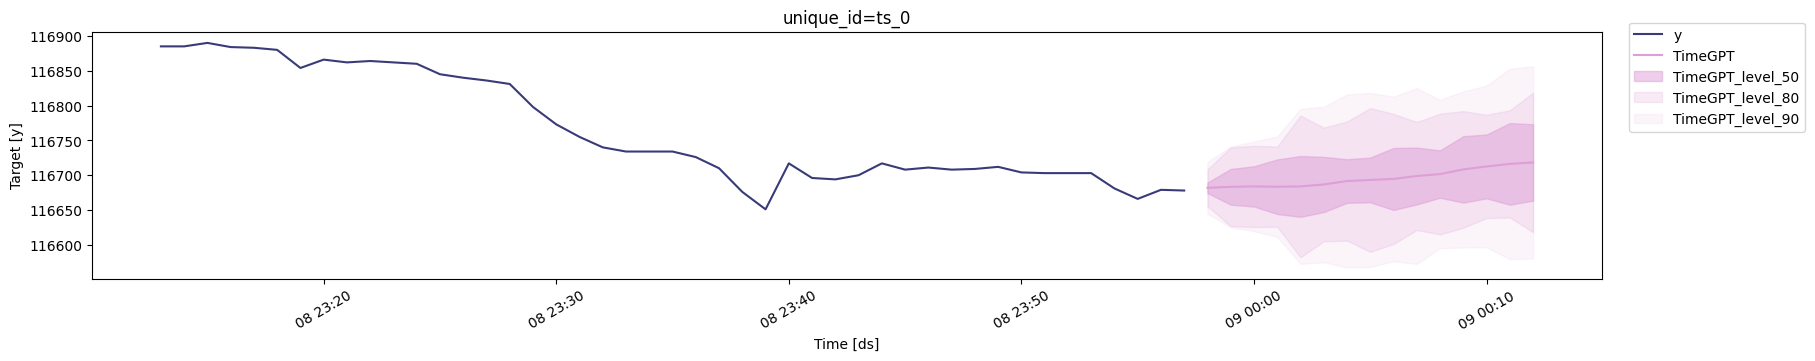

In [66]:
nixtla_client.plot(df, fcst, level=level, max_insample_length=45)

We can pass the forecasts we just generated to the `plot` method to visualize the predictions with the historical data.  

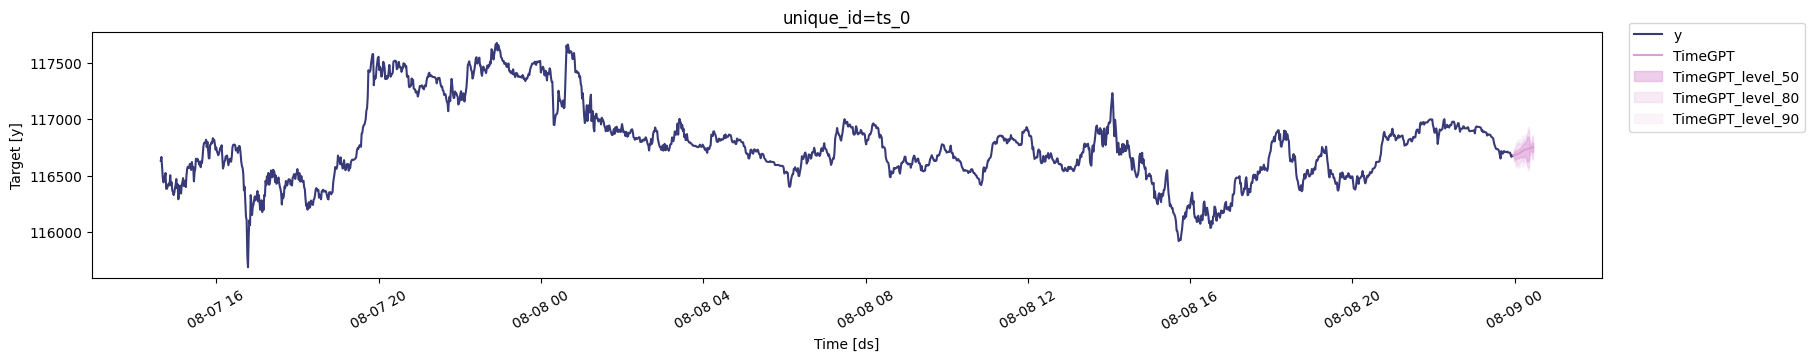

In [63]:
nixtla_client.plot(df, fcst, level=level)

Additionally, if you set the `add_history` argument of the `forecast` method to `True`, `TimeGPT` will generate predictions for the historical observations too. This can be useful for assessing the model's performance on the training data.

In [47]:
forecast = nixtla_client.forecast(df, h=15, level=level, add_history=True)
forecast.head()

,ds,TimeGPT,TimeGPT-hi-50,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-50,TimeGPT-lo-80,TimeGPT-lo-90
0,2025-05-31 15:34:00,104738.56,104865.750,104980.22,105048.72,104611.375,104496.910,104428.410
1,2025-05-31 15:35:00,104716.10,104843.290,104957.76,105026.26,104588.914,104474.445,104405.945
2,2025-05-31 15:36:00,104710.13,104837.320,104951.79,105020.29,104582.945,104468.480,104399.980
3,2025-05-31 15:37:00,104705.84,104833.030,104947.50,105016.00,104578.660,104464.190,104395.690
4,2025-05-31 15:38:00,104707.94,104835.125,104949.59,105018.09,104580.750,104466.280,104397.780


> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

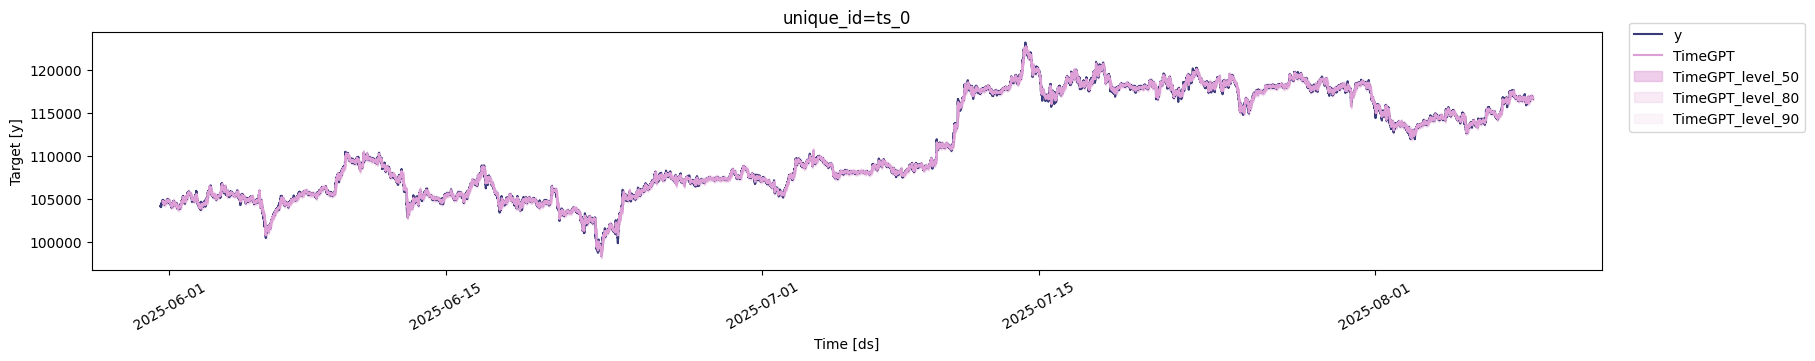

In [48]:
nixtla_client.plot(df, forecast, level=level)

## 5. Extend Bitcoin Price Analysis with TimeGPT

### Anomaly Detection

Given the volatility of the price of Bitcoin, it can be useful to try to identify anomalies in the data. `TimeGPT` can be used for this by calling the `detect_anomalies` method from the `NixtlaClient` class. This method evaluates each observation against its context within the series, using statistical measures to determine its likelihood of being an anomaly. By default, it identifies anomalies based on a 99 percent prediction interval. To change this, you can specify the `level` argument.

In [49]:
anomalies_df = nixtla_client.detect_anomalies(df)

> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.detect_anomalies(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

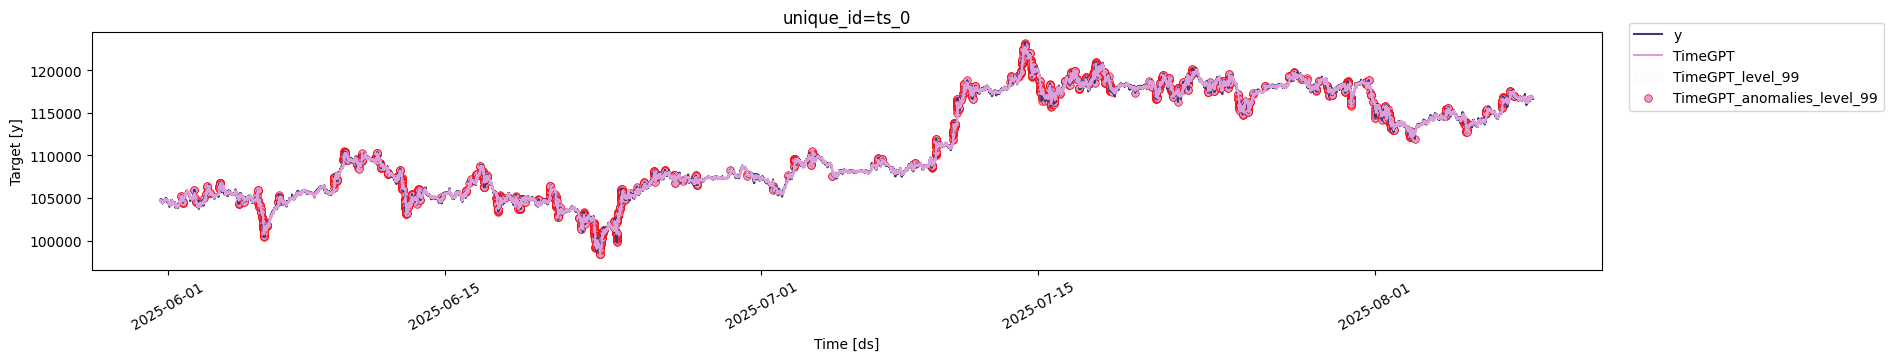

In [50]:
nixtla_client.plot(df, anomalies_df, plot_anomalies=True)

To learn more about how to detect anomalies with `TimeGPT`, take a look at our [Anomaly Detection](https://docs.nixtla.io/docs/capabilities-anomaly-detection-anomaly_detection) tutorial.   

### Add Exogenous Variables

If you have additional information that you believe could help improve the forecast, consider including it as an exogenous variable. For instance, you might add data such as the price of other cryptocurrencies, proprietary information, stock market indices, or the number of transactions in the Bitcoin network.

`TimeGPT` supports the incorporation of exogenous variables in the `forecast` method. However, keep in mind that you'll need to know the future values of these variables.

To learn how to incorporate exogenous variables to `TimeGPT`, refer to the [Exogenous Variables](https://docs.nixtla.io/docs/tutorials-exogenous_variables) tutorial.

## 6. Understand the Model's Limitations

As stated in the introduction, predicting the future prices of financial assets is a challenging task, especially for assets like Bitcoin. The predictions in this tutorial may appear accurate, mainly because they align with recent historical data and the model updates with new values at short intervals, avoiding significant deviations. However, the true challenge lies in forecasting Bitcoin's price for the upcoming days, not just its historical performance. For those who need or want to try to forecast these assets, `TimeGPT` can be an option that simplifies the forecasting process. With just a couple of lines of code, `TimeGPT` can help you:

- Produce point forecasts
- Quantify the uncertainty of your predictions
- Produce in-sample forecasts
- Detect anomalies
- Incorporate exogenous variables

To learn more about `TimeGPT` capabilities, please refer to the [TimeGPT Documentation](https://docs.nixtla.io/).

## 7. References and Additional Material

**References**

* [Joaquín Amat Rodrigo and Javier Escobar Ortiz (2022), "Bitcoin price prediction with Python, when the past does not repeat itself"](https://www.cienciadedatos.net/documentos/py41-forecasting-cryptocurrency-bitcoin-machine-learning-python.html)

Furthermore, for many financial time series, the best estimate for the price is often a random walk model, meaning that the best forecast for tomorrow's price is today's price. Nixtla's [StatsForecast](https://nixtlaverse.nixtla.io/statsforecast/index.html) library allows you to easily implement this model and variations.